# Importing Dataset and Packages

In [1]:
from utils import *

# Observing Dataset Structure and Summary Statistics

In [2]:
dataset = pd.read_csv('sales.csv') 
observe_data_structure(dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4612716 entries, 0 to 4612715
Data columns (total 4 columns):
date         object
store_nbr    int64
item_nbr     int64
units        int64
dtypes: int64(3), object(1)
memory usage: 140.8+ MB
None

 Summary Statistics 

          store_nbr      item_nbr         units
count  4.612716e+06  4.612716e+06  4.612716e+06
mean   2.309135e+01  5.600000e+01  9.879201e-01
std    1.295266e+01  3.204164e+01  9.880973e+00
min    1.000000e+00  1.000000e+00  0.000000e+00
25%    1.200000e+01  2.800000e+01  0.000000e+00
50%    2.300000e+01  5.600000e+01  0.000000e+00
75%    3.400000e+01  8.400000e+01  0.000000e+00
max    4.500000e+01  1.110000e+02  5.568000e+03


*When dataset.describe is run to get the summary statistics of the dataset, summary statistics are also calculated for **store_nbr** and **item_nbr**, though they are actually categorical variables. This should not be so. Hence, I did not include them in Figure 2 in the written report.*

In [3]:
#Summary Statistics of the only numeric variable in the dataset
dataset.units.describe()

count    4.612716e+06
mean     9.879201e-01
std      9.880973e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.568000e+03
Name: units, dtype: float64

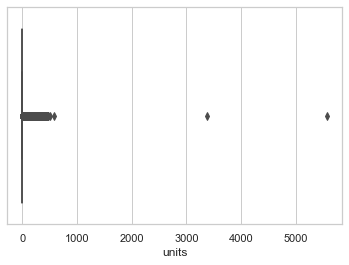

In [4]:
#Plotting distribution of the units variable
sns.boxplot(x=dataset.units)

# Data pre-processing

The training set has at least 2 previous timestamps for each day of the years 2012 and 2013. Christmas Day for both years is excluded due to missing data. The test set is data from 1st of January 2014 onwards. 

In [5]:
#Changing date to date_time object
dataset.date = pd.to_datetime(dataset.date)

#Creating train variable to indicate whether an entry is in the train 
#or test set. 1 is for train set, 0 is for test set

dataset['train'] = 1
dataset.loc[dataset.date > datetime.datetime(2013, 12, 31), 'train'] = 0

#Splitting into train and test set

train = split_data_and_drop_train_column(dataset, 1)
test = split_data_and_drop_train_column(dataset, 0)

## Finding the best and worst selling items

Because of the high number of items, I displayed the items with the 5 highest and 5 lowest total sales. I am using a table to display the information because of the large gap between the order of figures in the *Total Number sold* column. As mentioned in the paper, I would be using the best selling item for the rest of my analysis.

In [6]:
best_and_worst_selling_items(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,Item_Number,Total number sold
0,21,0.0
1,109,0.0
2,110,0.0
3,101,15.0
4,33,53.0
5,15,178509.0
6,43,450132.0
7,4,659793.0
8,8,690599.0
9,44,777141.0


# Forecasting best selling item

Going by the table above, this analysis would be focused on **Item 44**, as it is the best selling item in the dataset. 
Here, all the sales of **Item 44** made across all the 45 stores in the dataset, for each day in the training and test sets are combined. This puts the data in an ideal time series format.

*If this analysis was to be modified for any other item in the dataset, the corresponding **item_nbr** just needs to be entered.*

In [7]:
#Reformatting dataset
item_number = 44

train_trend = reformatting_data(train, item_number)
test_trend = reformatting_data(test, item_number)

## Plotting Time Series Decomposition

With time series decomposition, we can see the observed time series and the trend, seasonality and residuals of the observed time series.  

As highlighted in the paper, we can reasonably assume this time series could have both weekly and annual seasonality. This is represented by the frequency in the function below; 7 is for weekly seasonality and 365 is for annual seasonality. 

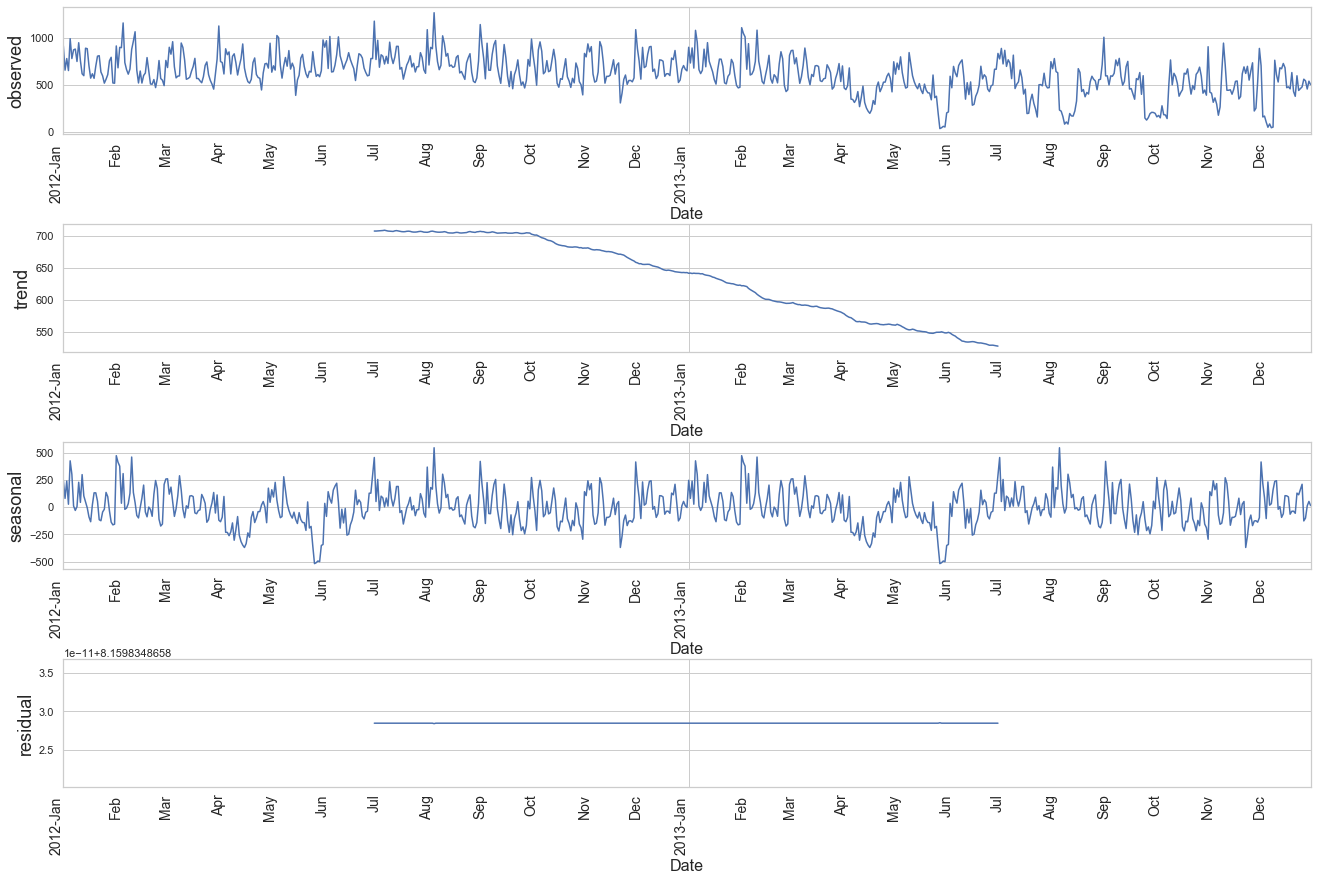

In [8]:
#Annual seasonality
plot_seasonal_decomposition(train_trend.units,train_trend.date,365)

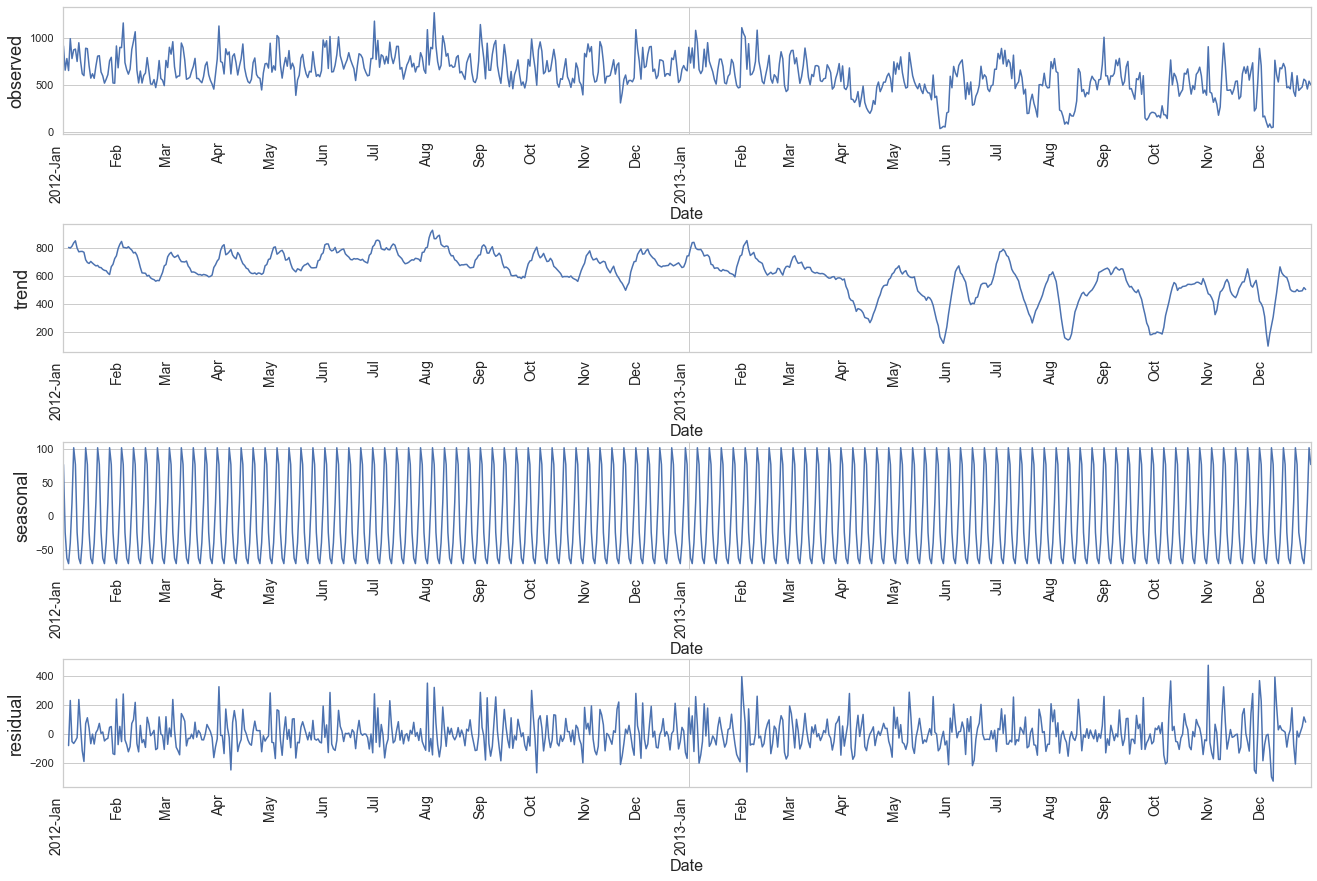

In [9]:
#Weekly seasonality
plot_seasonal_decomposition(train_trend.units,train_trend.date,7)

From the plots above, looking at the residuals which show the remaining data that was not captured by the trend and seasonality measures, the annual seasonality decomposition does a better job at helping us understand the time series better as it has less variation in the residuals. As this is not a model but just a way to better understand the features of the data to help with modelling, we do not have to check if the residuals are independent, uncorrelated and homoskedastic. 

On the other hand, the weekly seasonality decomposition shows some seasonality. However, it has larger residuals and the trend does not show a clear direction in the increase or decrease of sales, whether linear or exponential.

## Hypothesizing what Item 44 could be

Looking at the total sales for each day of the week and the total sales in each month could give insights that could help in hypothesising what Item 44 could possibly be, by looking at what days and months the product was sold most in, in total.

In [10]:
#Getting day of week and month of year variables as numbers from date
train_trend['Month'] = train_trend['date'].dt.month

#Making Monday first day of week with 1; Sunday as 7
train_trend['Day'] = train_trend['date'].dt.weekday + 1 

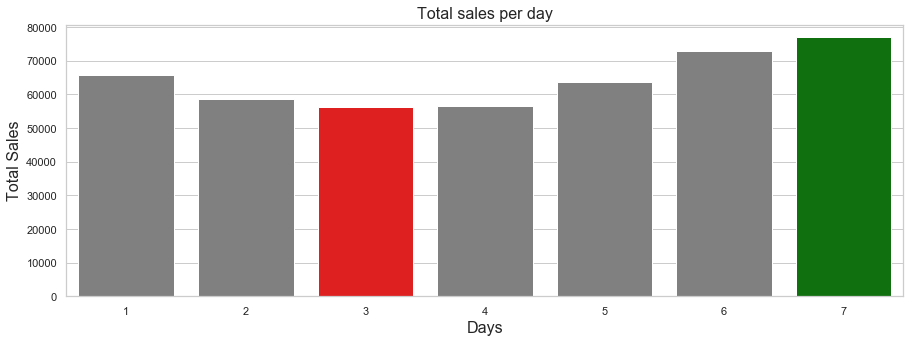

In [11]:
#Finding the most profitable day of the week

total_daily_sales = list(train_trend.groupby('Day').sum()["units"])
day_of_week = list(range(1,8))

eda_plots(total_daily_sales, day_of_week, 'Days','Total sales per day')

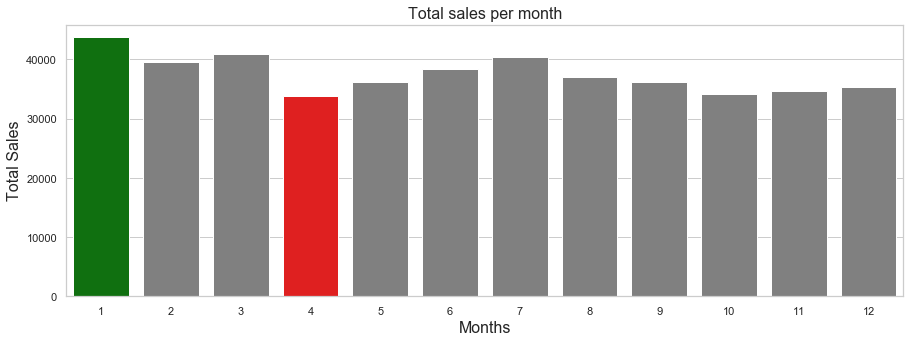

In [12]:
#Finding the most profitable month in the year

total_monthly_sales = list(train_trend.groupby('Month').sum()["units"])
months = list(range(1,13))

eda_plots(total_monthly_sales, months, 'Months','Total sales per month')

In [13]:
#Dropping the extra columns
train_trend = train_trend.drop(columns = ['Day', 'Month'])

**Gotten from my Capstone paper** 

From the figures above, we can see that Item 44 sells the most on the weekends and sells the most in January, followed by March and July. My hypothesis is that Item 44 might be junk food, for example, crisps. I can reasonably assume that they would be sold more on weekends if we consider that people would buy them for ‘cheat days’ or as snacks when they have gatherings with friends during the weekend. Throughout the year, they are sold in good amounts, which makes sense because people would always snack. They would be sold more in January if we consider that people might be buying them as comfort food because of the cold weather and possibly stocking up before the Super Bowl in February. I assume people would buy relatively less junk food in April in preparation for the summer, where everyone tries to look their best physically, and then during the summer months, they would ease up on that and focus on having fun, eating and relaxing with friends, especially around the 4th of July holiday.

### Appendix: Making Data Stationary

Making the time series stationary means to remove any obvious trends or seasonality in the dataset and it is usually done for ARIMA models to get the appropriate differencing term to be put in the model in order to get proper results (Hyndman & Athanasopoulos, 2018). Though it is not necessary for the models I am considering in my application (Hyndman & Athanasopoulos, 2018; Letham, 2019), I am doing this to just see if my data is stationary and using this to show my knowledge of the usual pre-processing of time series for the popular ARIMA models. 

To make the data stationary, differencing and log-transformations can be used, depending on whether one of the methods initially worked or not. To see if the dataset is stationary, the p-value in the Dickey-Fuller test has to be less than or equal to 0.05.

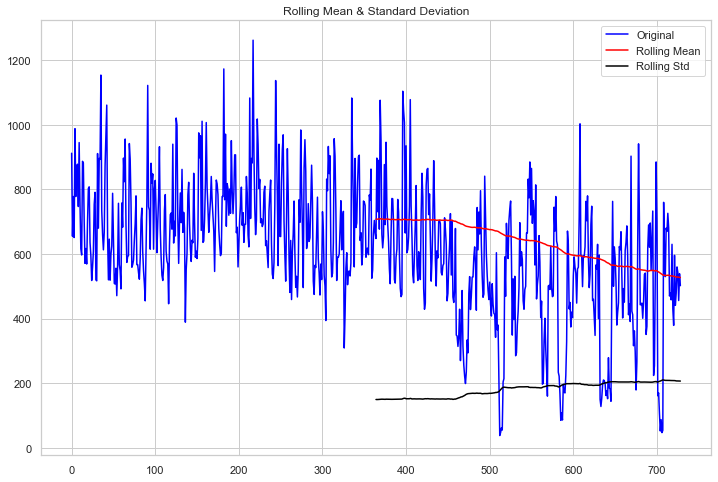

Results of Dickey-Fuller Test:
Test Statistic                  -2.795479
p-value                          0.058923
#Lags Used                      20.000000
Number of Observations Used    708.000000
Critical Value (1%)             -3.439620
Critical Value (5%)             -2.865631
Critical Value (10%)            -2.568948
dtype: float64


In [14]:
#Testing if training set data is stationary
test_stationarity(train_trend.units)

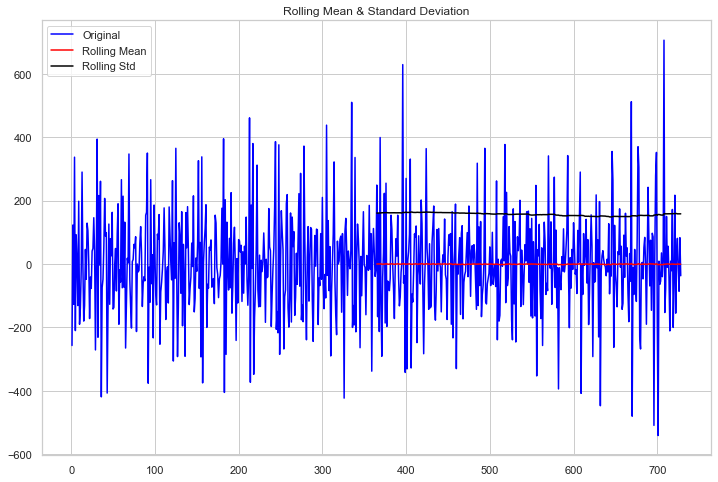

Results of Dickey-Fuller Test:
Test Statistic                -1.099373e+01
p-value                        6.955178e-20
#Lags Used                     1.900000e+01
Number of Observations Used    7.080000e+02
Critical Value (1%)           -3.439620e+00
Critical Value (5%)           -2.865631e+00
Critical Value (10%)          -2.568948e+00
dtype: float64


In [15]:
#Differencing data
differenced_data = train_trend.units - train_trend.units.shift(1)
differenced_data = differenced_data.dropna()

#Testing if differenced data is stationary
test_stationarity(differenced_data)

In [16]:
# Saving datasets to .csv files for the feature engineering notebook

train_trend = train_trend.to_csv(r'train_trend.csv',\
                                 index = None, header=True)
test_trend = test_trend.to_csv(r'test_trend.csv',\
                               index = None, header=True)